In [6]:
import matplotlib.pyplot as plt
from imp import reload
from typing import List
import os
import pickle
import pandas as pd
import numpy as np
import sys
import cv2

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from data_utils import DataHandler
import evaluate
import histogram_processing
import detect_textbox
import similarities
import bg_masks
import image_utils
import image_features
import data_utils


# from text_retrieval import *
import text_retrieval


N_PROCESS = 10

# Load Data

In [7]:
data_handler = DataHandler()

# Load images:
db, db_files = data_handler.load_images(folder = "../data/BBDD/", extension = ".jpg", desc = "Loading BBDD Data...")
qsd1_w2, qsd1_w2_files = data_handler.load_images(folder = "../data/qsd1_w2/", extension = ".jpg", desc = "Loading qsd1_w2 Data...")
qsd1_w3, qsd1_w3_files = data_handler.load_images(folder = "../data/qsd1_w3/", extension = ".jpg", desc = "Loading qsd1_w3 Data...")
qsd2_w3, qsd2_w3_files = data_handler.load_images(folder = "../data/qsd2_w3/", extension = ".jpg", desc = "Loading qsd2_w3 Data...")

# Load text:
db_text = data_handler.load_text(folder = "../data/BBDD/", extension = ".txt", desc = "Loading BBDD Text data...")
qsd1_w2_text = data_handler.load_text(folder = "../data/qsd1_w2/", extension = ".txt", desc = "Loading qsd1_w2 Text data...")
qsd1_w3_text = data_handler.load_text(folder = "../data/qsd1_w3/", extension = ".txt", desc = "Loading qsd1_w3 Text data...")
qsd2_w3_text = data_handler.load_text_multiple(folder = "../data/qsd2_w3/", extension = ".txt", desc = "Loading qsd2_w3 Text data...")

Initialized DataHandler with 2 processes


Loading BBDD Data...: 100%|██████████| 287/287 [00:04<00:00, 58.18it/s]


../data/BBDD/ read: 287 images


Loading qsd1_w2 Data...: 100%|██████████| 30/30 [00:00<00:00, 410.96it/s]


../data/qsd1_w2/ read: 30 images


Loading qsd1_w3 Data...: 100%|██████████| 30/30 [00:00<00:00, 573.00it/s]


../data/qsd1_w3/ read: 30 images


Loading qsd2_w3 Data...: 100%|██████████| 30/30 [00:00<00:00, 113.91it/s]


../data/qsd2_w3/ read: 30 images


Loading BBDD Text data...: 100%|██████████| 287/287 [00:00<00:00, 12927.87it/s]


../data/BBDD/ read: 287 images


Loading qsd1_w2 Text data...: 100%|██████████| 30/30 [00:00<00:00, 7777.79it/s]


../data/qsd1_w2/ read: 30 images


Loading qsd1_w3 Text data...: 100%|██████████| 30/30 [00:00<00:00, 7290.64it/s]


../data/qsd1_w3/ read: 30 images


Loading qsd2_w3 Text data...: 100%|██████████| 30/30 [00:00<00:00, 7403.89it/s]


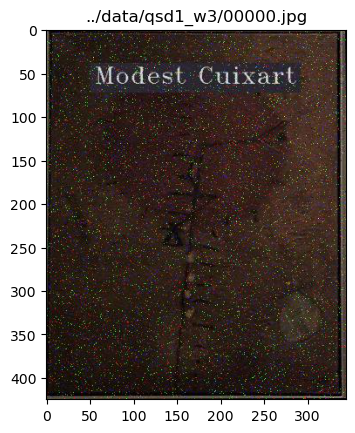

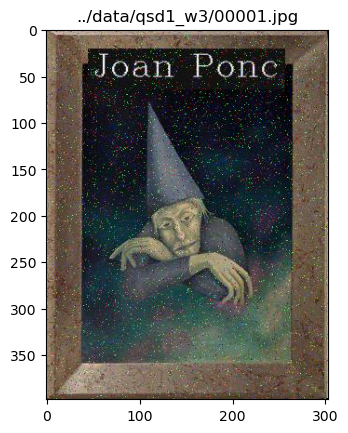

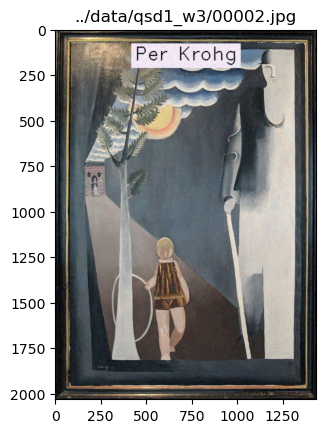

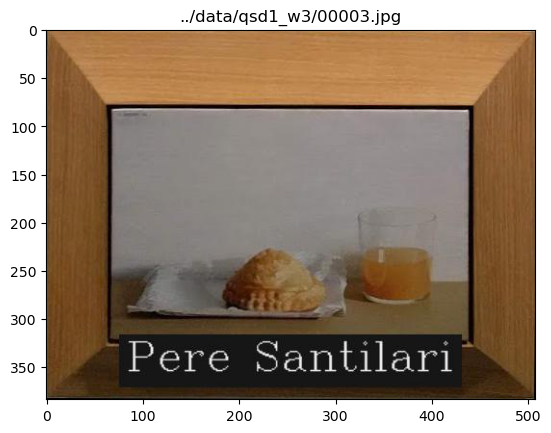

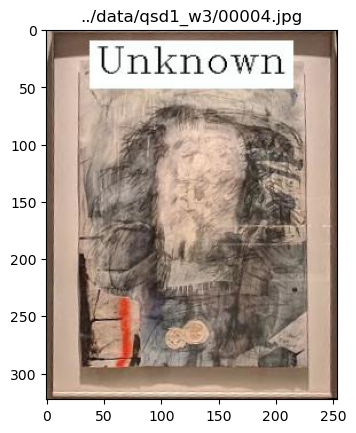

In [8]:
for i, (img, filename) in enumerate(zip(qsd1_w3, qsd1_w3_files)):
    plt.imshow(img)
    plt.title(filename)
    plt.show()
    if i > 3:
        break

### Plot real image and similar image for one picture

In [9]:
from skimage.io import imread

def plot_image_and_similar(qs, top_k_qs) -> None:

    for i in range(min(5, len(qs))):
        f, axarr = plt.subplots(1, 2, figsize=(10, 10))
        query = qs[i]
        res = imread(top_k_qs[i][0])
        axarr[0].imshow(query)
        axarr[0].title.set_text("Query")
        axarr[1].imshow(res)
        axarr[1].title.set_text("Result")
        plt.show()
        
def plot_image_and_similars(db, qs, top_k_qs) -> None:

    for i in range(min(5, len(qs))):
        f, axarr = plt.subplots(1, 4, figsize=(10, 10))
        axarr[0].imshow(qs[i])
        res_0 = top_k_qs[i][0]
        res_1 = top_k_qs[i][1]
        res_2 = top_k_qs[i][2]
        axarr[1].imshow(db[int(res_0[-9:-4])])
        axarr[2].imshow(db[int(res_1[-9:-4])])
        axarr[3].imshow(db[int(res_2[-9:-4])])
        plt.show()
        
def plot_image_and_similar_painter(db, db_text, qs, qs_text, top_k_qs) -> None:

    for i in range(min(4, len(qs))):
        f, axarr = plt.subplots(1, 4, figsize=(10, 10))
        axarr[0].imshow(qs[i])
        axarr[0].title.set_text(qs_text[i][0])
        res_0 = top_k_qs[i][0]
        res_1 = top_k_qs[i][1]
        res_2 = top_k_qs[i][2]
        axarr[1].imshow(db[res_0])
        axarr[1].title.set_text(db_text[res_0][0])
        axarr[2].imshow(db[res_1])
        axarr[2].title.set_text(db_text[res_1][0])
        axarr[3].imshow(db[res_2])
        axarr[3].title.set_text(db_text[res_2][0])
        plt.show()
        
def plot_image_and_similar_painting(db, db_text, qs, qs_text, top_k_qs) -> None:

    for i in range(min(4, len(qs))):
        f, axarr = plt.subplots(1, 4, figsize=(10, 10))
        axarr[0].imshow(qs[i])
        axarr[0].title.set_text(qs_text[i][1])
        res_0 = top_k_qs[i][0]
        res_1 = top_k_qs[i][1]
        res_2 = top_k_qs[i][2]
        axarr[1].imshow(db[res_0])
        axarr[1].title.set_text(db_text[res_0][1])
        axarr[2].imshow(db[res_1])
        axarr[2].title.set_text(db_text[res_1][1])
        axarr[3].imshow(db[res_2])
        axarr[3].title.set_text(db_text[res_2][1])
        plt.show()

## Task 2

In [10]:
pred_texts_greys_qsd1_w2_folder = './results/text/pred_texts_greys_qsd1_w2/'
pred_texts_greys_qsd1_w2 = data_handler.load_text(folder = pred_texts_greys_qsd1_w2_folder, extension = ".txt", desc = "Loading Predicted Text data...", tuples=False)
top_3_text_multiple_qsd1_w2 = text_retrieval.get_top_k_text_multiple(pred_texts_greys_qsd1_w2, db_text, k=3, dist = 'damerau_levenshtein')

Loading Predicted Text data...: 100%|██████████| 30/30 [00:00<00:00, 10563.22it/s]


./results/text/pred_texts_greys_qsd1_w2/ read: 30 images


Retrieving top 3 results from Text using DAMERAU_LEVENSHTEIN distance: 100%|██████████| 30/30 [00:01<00:00, 16.06it/s]


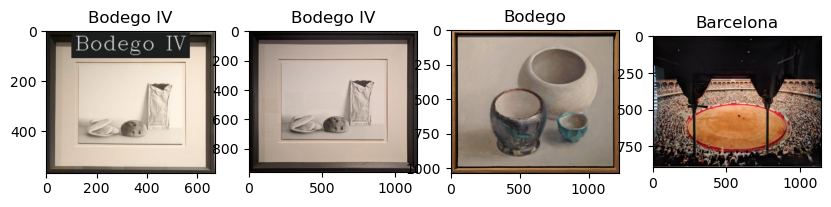

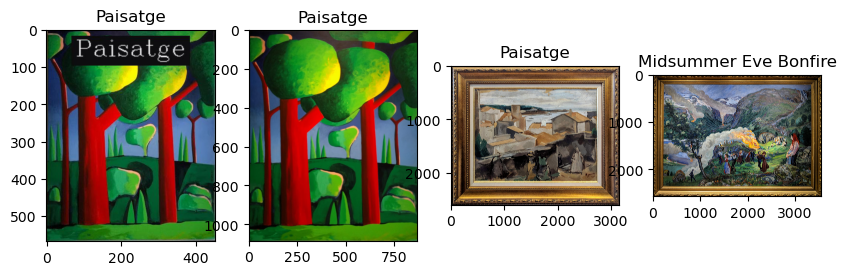

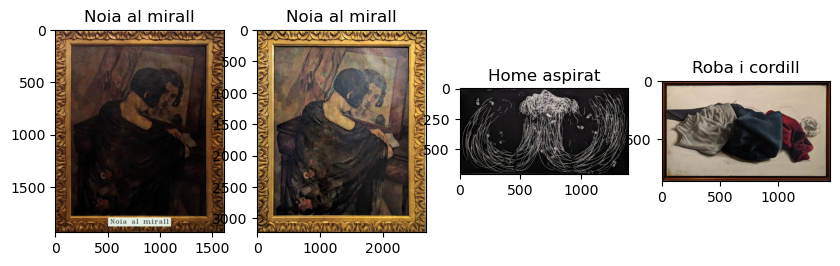

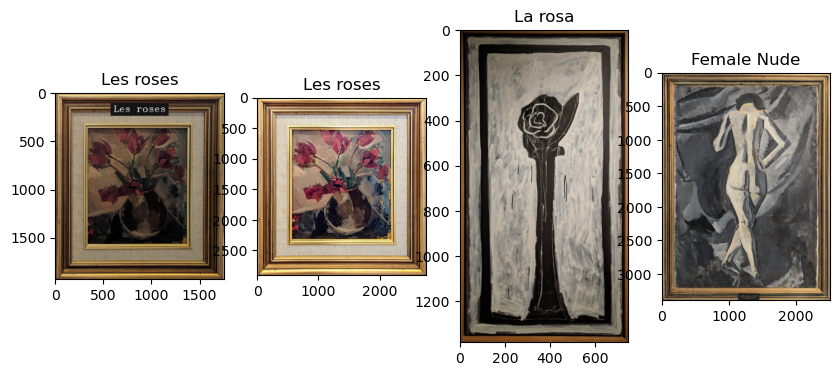

In [11]:
plot_image_and_similar_painting(db, db_text, qsd1_w2, qsd1_w2_text, top_3_text_multiple_qsd1_w2)

## Task 3

### HoG

In [12]:
db_texture_matrix = image_features.hog_batch(images = db[:], mssg="Histograms of Gradients (HoG) from BBDD...")
qsd1_w2_texture_matrix = image_features.hog_batch(images = qsd1_w2[:], mssg="Histograms of Gradients (HoG) from qsd1_w2...")

Histograms of Gradients (HoG) from qsd1_w2...: 100%|██████████| 30/30 [00:00<00:00, 44.41it/s]


In [13]:
print (f'We have {qsd1_w2_texture_matrix.shape[0]} images, each with a {qsd1_w2_texture_matrix.shape[1]} dimensional descriptor')

We have 30 images, each with a 300 dimensional descriptor


/var/folders/pv/m0d2tn25285cc_5x46fswyjr0000gn/T/ipykernel_15090/3443643721.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  i = list(qsd1_w2).index(im)


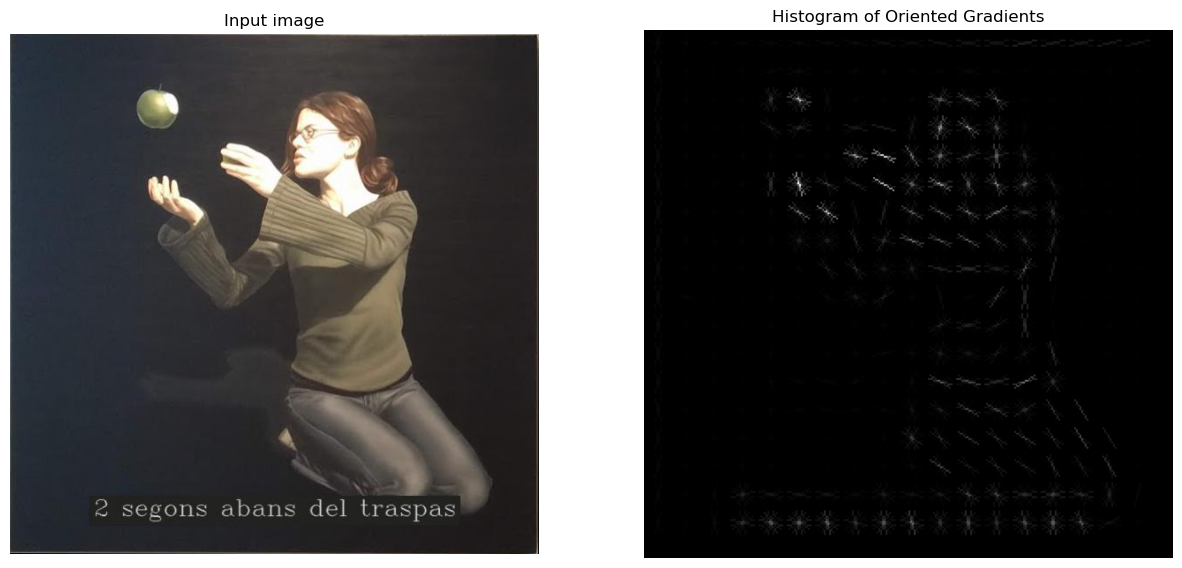

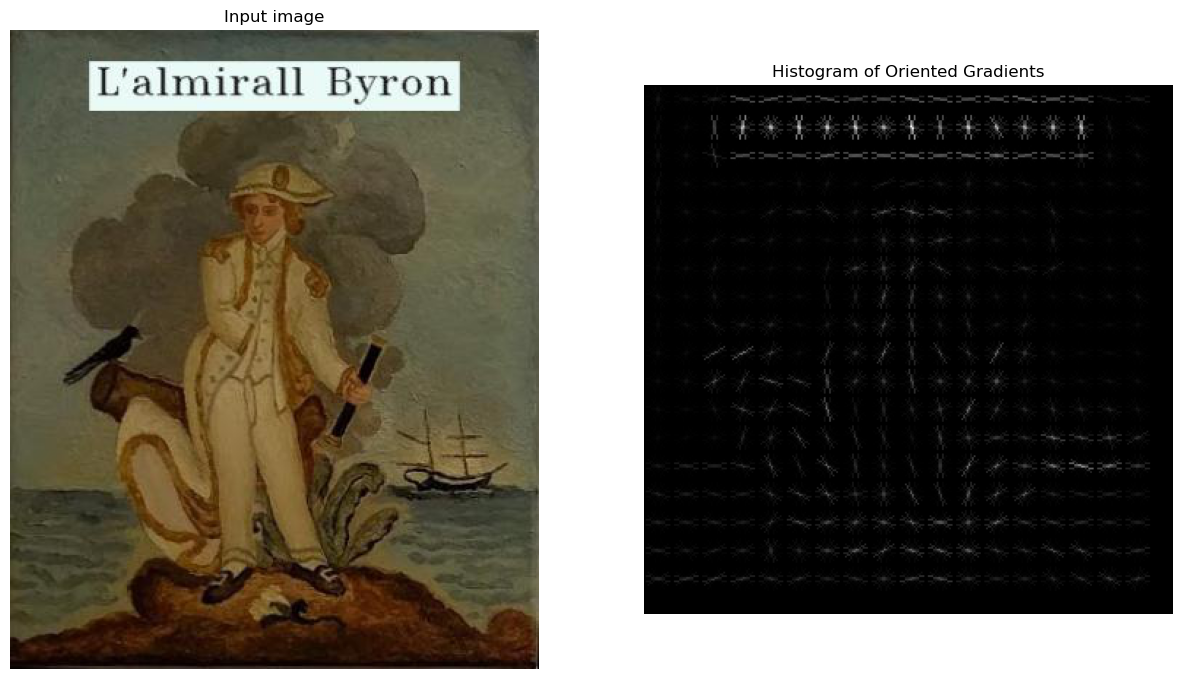

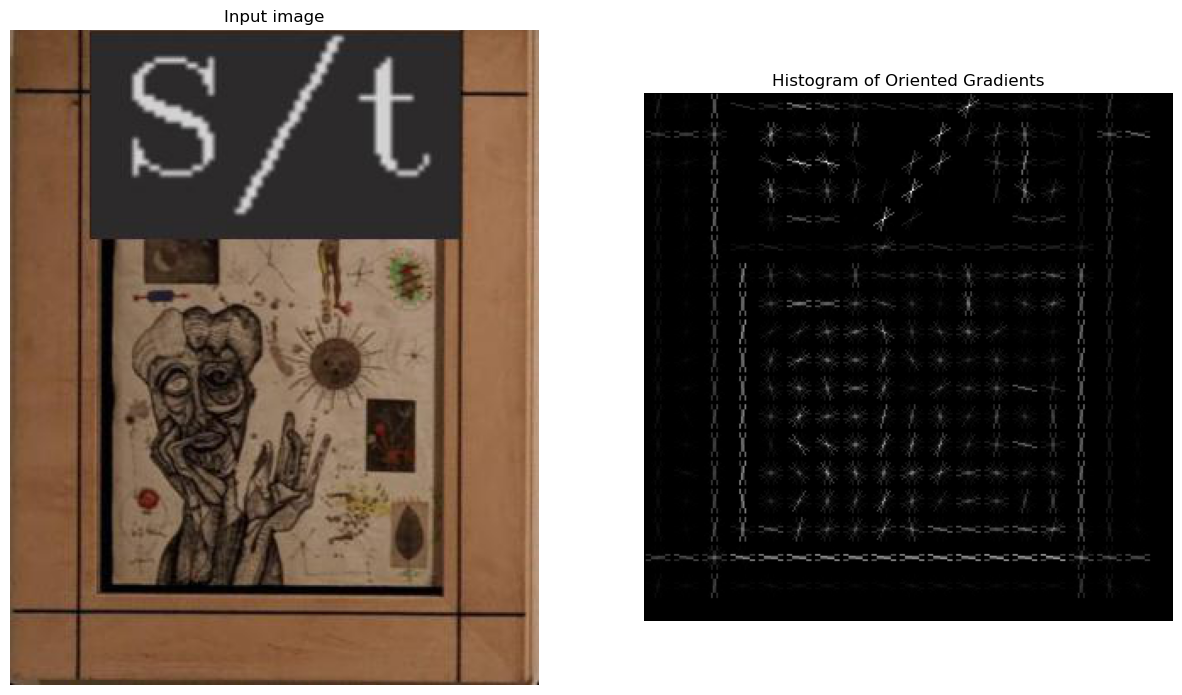

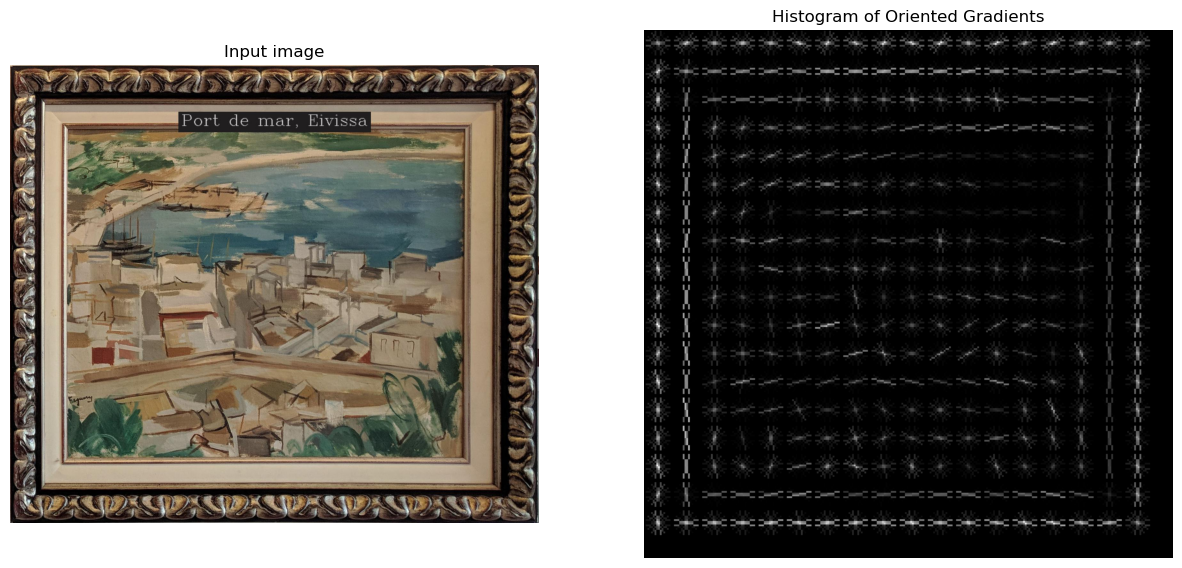

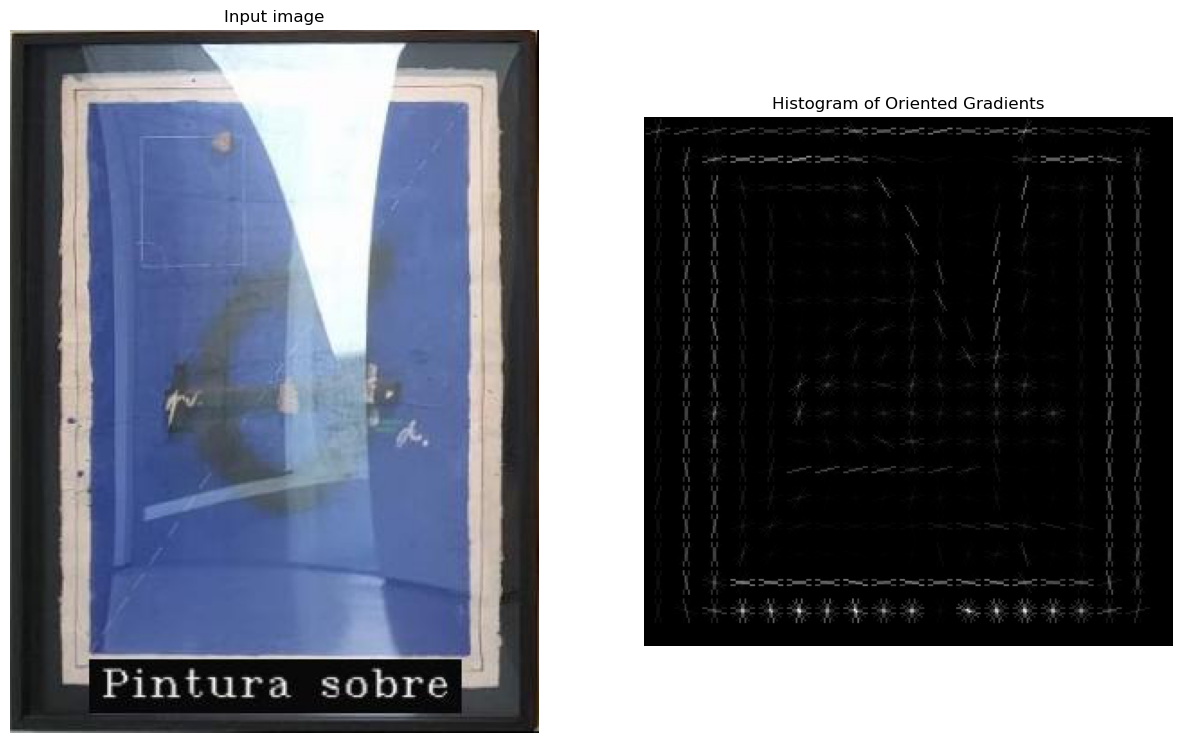

In [14]:
from skimage.exposure import rescale_intensity

for im in qsd1_w2[4:9]:
    i = list(qsd1_w2).index(im)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    ax1.axis('off')
    ax1.imshow(im, cmap=plt.cm.gray)
    ax1.set_title('Input image')

    hog_image_rescaled = rescale_intensity(qsd1_w2_texture_matrix[i], in_range=(0, 10))

    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()

In [15]:
reload(similarities)
qsd1_w2_similarity_matrix = similarities.compute_similarities_parallel(
    qsd1_w2_texture_matrix, db_texture_matrix, similarities.measures["hellinger_kernel"], "Computing similarities for HoG...", N_PROCESS
)

Computing similarities for HoG...: 100%|██████████| 30/30 [00:02<00:00, 14.96it/s]


In [16]:
evaluate.get_mapk(
    similarity_matrix=qsd1_w2_similarity_matrix,
    db_files=db_files,
    query_dataset="qsd1_w2",
    data_handler=data_handler,
    out_dir="../results/data/w3/HoG/",
)

Retrieving top 1 similar images for qsd1_w2...: 100%|██████████| 30/30 [00:00<00:00, 34332.64it/s]


Results saved at ../results/data/w3/HoG//qsd1_w2.pkl/result.pkl
MAP@1 Score: 96.6667% (29/30)


Retrieving top 5 similar images for qsd1_w2...: 100%|██████████| 30/30 [00:00<00:00, 25450.87it/s]


Results saved at ../results/data/w3/HoG//qsd1_w2.pkl/result.pkl
MAP@5 Score: 98.3333% (29/30)


Retrieving top 10 similar images for qsd1_w2...: 100%|██████████| 30/30 [00:00<00:00, 29296.65it/s]

Results saved at ../results/data/w3/HoG//qsd1_w2.pkl/result.pkl
MAP@10 Score: 98.3333% (29/30)


[[1, 96.66666666666667, 29, 30],
 [5, 98.33333333333333, 29, 30],
 [10, 98.33333333333333, 29, 30]]

### DCT

In [22]:
reload(image_features)
db_texture_matrix = image_features.dct_batch(images = db[:], quantize=True, mssg="Quantized DCT from BBDD...")
qsd1_w2_texture_matrix = image_features.dct_batch(images = qsd1_w2[:], quantize=True, mssg="Quantized DCT from qsd1_w2...")

Quantized DCT from BBDD...:  17%|█▋        | 48/287 [00:01<00:07, 29.90it/s]/Users/johnny/miniconda3/envs/Team1/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Quantized DCT from qsd1_w2...: 100%|██████████| 30/30 [00:00<00:00, 81.22it/s] 


In [23]:
print (f'We have {qsd1_w2_texture_matrix.shape[0]} images, each with a {qsd1_w2_texture_matrix.shape[1]} dimensional descriptor')

We have 30 images, each with a 4332 dimensional descriptor


In [24]:
import sklearn.decomposition
PCA_LBP = sklearn.decomposition.PCA(
    n_components=min(300, min(db_texture_matrix.shape[0], db_texture_matrix.shape[1])),
    random_state=1234,
)
db_texture_matrix_PCA = PCA_LBP.fit_transform(db_texture_matrix)
qsd1_w2_texture_matrix_PCA = PCA_LBP.transform(qsd1_w2_texture_matrix)

In [25]:
qsd1_w2_similarity_matrix = similarities.compute_similarities_parallel(
    qsd1_w2_texture_matrix_PCA, db_texture_matrix_PCA, similarities.measures["euclidean_distance"], "Computing similarities for DCT...", N_PROCESS
)

Computing similarities for DCT...: 100%|██████████| 30/30 [00:01<00:00, 16.76it/s]


In [26]:
evaluate.get_mapk(
    similarity_matrix=qsd1_w2_similarity_matrix,
    db_files=db_files,
    query_dataset="qsd1_w2",
    data_handler=data_handler,
    out_dir="../results/data/w3/HoG/",
)

Retrieving top 1 similar images for qsd1_w2...: 100%|██████████| 30/30 [00:00<00:00, 21308.91it/s]


Results saved at ../results/data/w3/HoG//qsd1_w2.pkl/result.pkl
MAP@1 Score: 70.0000% (21/30)


Retrieving top 5 similar images for qsd1_w2...: 100%|██████████| 30/30 [00:00<00:00, 28168.60it/s]


Results saved at ../results/data/w3/HoG//qsd1_w2.pkl/result.pkl
MAP@5 Score: 71.6667% (21/30)


Retrieving top 10 similar images for qsd1_w2...: 100%|██████████| 30/30 [00:00<00:00, 25507.63it/s]

Results saved at ../results/data/w3/HoG//qsd1_w2.pkl/result.pkl
MAP@10 Score: 71.6667% (21/30)


[[1, 70.0, 21, 30],
 [5, 71.66666666666667, 21, 30],
 [10, 71.66666666666667, 21, 30]]

### LBP

In [28]:
reload(image_features)
db_texture_matrix = image_features.lbp_batch(images = db[:], histogram = True, mssg="Quantized LBP from BBDD...", block=False)
qsd1_w2_texture_matrix = image_features.lbp_batch(images = qsd1_w2[:], histogram = True, mssg="Quantized LBP from qsd1_w2...", block=False)

Quantized LBP from BBDD...:  28%|██▊       | 80/287 [00:00<00:02, 73.29it/s] /Users/johnny/miniconda3/envs/Team1/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Quantized LBP from qsd1_w2...: 100%|██████████| 30/30 [00:00<00:00, 491.74it/s]


In [29]:
print (f'We have {qsd1_w2_texture_matrix.shape[0]} images, each with a {qsd1_w2_texture_matrix.shape[1]} dimensional descriptor')

We have 30 images, each with a 16 dimensional descriptor


In [30]:
import sklearn.decomposition
PCA_LBP = sklearn.decomposition.PCA(
    n_components=min(300, min(db_texture_matrix.shape[0], db_texture_matrix.shape[1])),
    random_state=1234,
)
db_texture_matrix_PCA = PCA_LBP.fit_transform(db_texture_matrix)
qsd1_w2_texture_matrix_PCA = PCA_LBP.transform(qsd1_w2_texture_matrix)

In [31]:
print (f'We have {qsd1_w2_texture_matrix_PCA.shape[0]} images, each with a {qsd1_w2_texture_matrix_PCA.shape[1]} dimensional descriptor')

We have 30 images, each with a 16 dimensional descriptor


In [32]:
evaluate.get_mapk(
    similarity_matrix=qsd1_w2_similarity_matrix,
    db_files=db_files,
    query_dataset="qsd1_w2",
    data_handler=data_handler,
    out_dir="../results/data/w3/HoG/",
)

Retrieving top 1 similar images for qsd1_w2...: 100%|██████████| 30/30 [00:00<00:00, 23772.74it/s]


Results saved at ../results/data/w3/HoG//qsd1_w2.pkl/result.pkl
MAP@1 Score: 70.0000% (21/30)


Retrieving top 5 similar images for qsd1_w2...: 100%|██████████| 30/30 [00:00<00:00, 28244.47it/s]


Results saved at ../results/data/w3/HoG//qsd1_w2.pkl/result.pkl
MAP@5 Score: 71.6667% (21/30)


Retrieving top 10 similar images for qsd1_w2...: 100%|██████████| 30/30 [00:00<00:00, 22469.49it/s]

Results saved at ../results/data/w3/HoG//qsd1_w2.pkl/result.pkl
MAP@10 Score: 71.6667% (21/30)


[[1, 70.0, 21, 30],
 [5, 71.66666666666667, 21, 30],
 [10, 71.66666666666667, 21, 30]]

# Task 4

### Filter noise

In [33]:
#Load denoised images:
qsd1_w3, qsd1_w3_files = data_handler.load_images(folder = "../data/qsd1_w3_denoised/", extension = ".png", desc = "Loading qsd1_w3_denoised Data...")

Loading qsd1_w3_denoised Data...: 100%|██████████| 30/30 [00:01<00:00, 20.87it/s]


../data/qsd1_w3_denoised/ read: 30 images


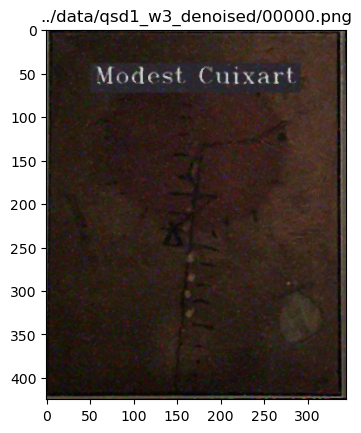

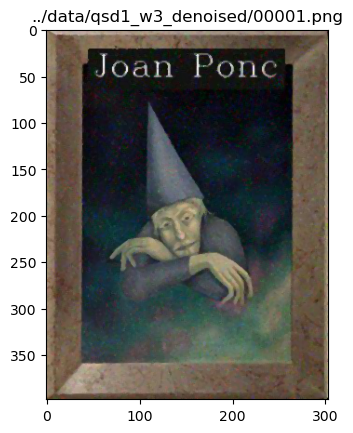

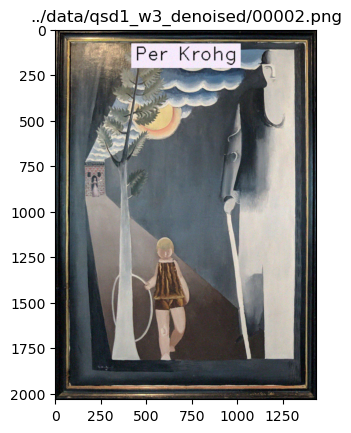

In [34]:
#Show denoised images:
for i, (img, filename) in enumerate(zip(qsd1_w3, qsd1_w3_files)):
    plt.imshow(img)
    plt.title(filename)
    plt.show()
    if i > 1:
        break

### Masks for text removal

In [35]:
# Week 2 method for text removal:
from skimage.io import imsave
# Find text bounding box.
for i, (img, filename) in enumerate(zip(qsd1_w3, qsd1_w3_files)):
    # Find text bounding box.
    bbox_pred = detect_textbox.find_text_bounding_box(qsd1_w3[i], kernel_shape = (10, 30))
    
    # Snap negative bbox detected points to origin of image (0), if needed.
    bbox_pred = [0 if c < 0 else c for c in bbox_pred]
    
    # Save predicted masks in folder.
    bbox_mask = detect_textbox.create_textbox_mask(img.shape[0:2], bbox_pred)
    mask_filename = filename[-9:]
    imsave(
        os.path.join('../results/data/w3/bbox_mask_qsd1_w3/', mask_filename),
        (255*bbox_mask).astype(np.uint8),
        check_contrast=False)
    
# Load bbox_masks:
masks_text_qsd1_w3, masks_text_qsd1_w3_files = data_handler.load_images(
    folder=f"../results/data/w3/bbox_mask_qsd1_w3/",
    extension=".png",
    desc=f"Loading background text masks for QSD1-W3...")

Loading background text masks for QSD1-W3...: 100%|██████████| 30/30 [00:00<00:00, 1001.30it/s]

../results/data/w3/bbox_mask_qsd1_w3/ read: 30 images


### Method 1: Descriptors using only texture

In [36]:
reload(image_features)

# Selected texture descriptor for qsd1_w3:
print ('Selected texture descriptor: HoG')

db_texture_matrix = image_features.hog_batch(images = db[:], mssg="Histograms of Gradients (HoG) from BBDD...")
qsd1_w3_texture_matrix = image_features.hog_batch(images = qsd1_w3[:], mssg="Histograms of Gradients (HoG) from qsd1_w3...")

print (f'We have {qsd1_w3_texture_matrix.shape[0]} images, each with a {qsd1_w3_texture_matrix.shape[1]} dimensional descriptor')

Selected texture descriptor: HoG


Histograms of Gradients (HoG) from BBDD...:  14%|█▍        | 40/287 [00:02<00:09, 26.11it/s]/Users/johnny/miniconda3/envs/Team1/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Histograms of Gradients (HoG) from qsd1_w3...: 100%|██████████| 30/30 [00:00<00:00, 44.45it/s]


We have 30 images, each with a 300 dimensional descriptor


In [37]:
#Compute similarities for texture:
#similarity_matrix_qsd1_w3_texture = similarities.compute_similarities_parallel(
#    qsd1_w3_texture_matrix, db_texture_matrix, similarities.measures["hellinger_kernel"], "Computing similarities...", N_PROCESS
#)
reload(similarities)
from skimage.transform import resize
similarity_matrix_qsd1_w3_texture = similarities.compute_similarities_parallel(
    qsd1_w3_texture_matrix,
    db_texture_matrix,
    similarities.measures["hellinger_kernel"],
    "Computing similarities for HoG...",
    N_PROCESS,
    masks=[resize(image=mask, output_shape=(300,300)) for mask in masks_text_qsd1_w3]
)

Computing similarities for HoG...: 100%|██████████| 30/30 [00:01<00:00, 15.39it/s]


Retrieving top 1 similar images for qsd1_w3...: 100%|██████████| 30/30 [00:00<00:00, 24371.32it/s]


Results saved at ../results/data/w3/combine_descriptors/texture/qsd1_w3.pkl/result.pkl
MAP@1 Score: 93.3333% (28/30)


Retrieving top 5 similar images for qsd1_w3...: 100%|██████████| 30/30 [00:00<00:00, 26978.80it/s]


Results saved at ../results/data/w3/combine_descriptors/texture/qsd1_w3.pkl/result.pkl
MAP@5 Score: 94.4444% (28/30)


Retrieving top 10 similar images for qsd1_w3...: 100%|██████████| 30/30 [00:00<00:00, 28333.51it/s]


Results saved at ../results/data/w3/combine_descriptors/texture/qsd1_w3.pkl/result.pkl
MAP@10 Score: 95.0000% (28/30)


Retrieving top 1 similar images for qs1_w3...: 100%|██████████| 30/30 [00:00<00:00, 31815.20it/s]


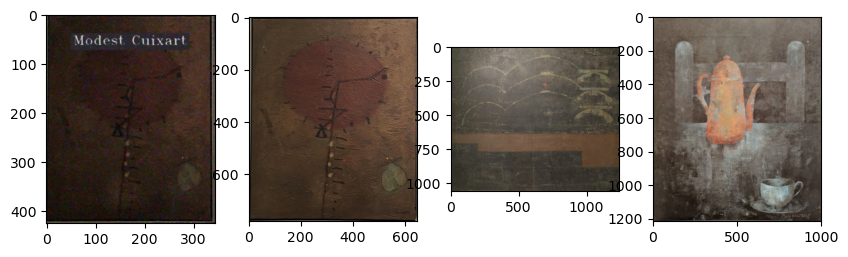

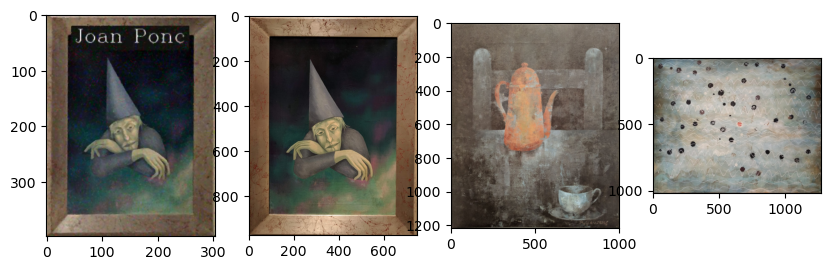

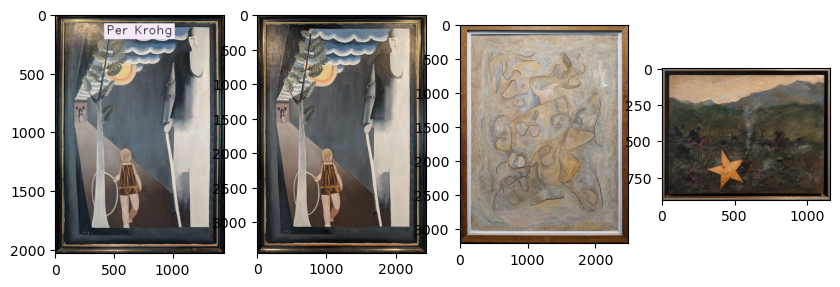

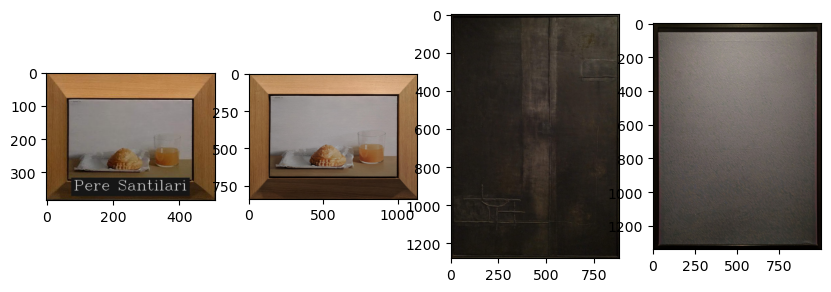

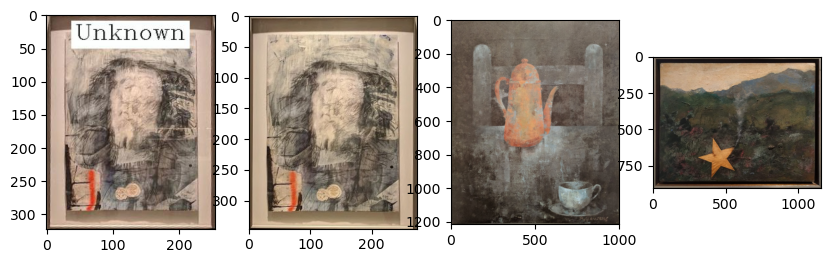

In [38]:
evaluate.get_mapk(similarity_matrix=similarity_matrix_qsd1_w3_texture, db_files=db_files,
    query_dataset="qsd1_w3", data_handler=data_handler, out_dir="../results/data/w3/combine_descriptors/texture",
)

top_5 = evaluate.get_top_k(similarity_matrix=similarity_matrix_qsd1_w3_texture, db_files=db_files,
                                         k=5, mssg="Retrieving top 1 similar images for qs1_w3...")

plot_image_and_similars(db, qsd1_w3, top_5)

### Method 2: Descriptors using only text

In [39]:
reload(text_retrieval)
similarity_matrix_qsd1_w3_text = text_retrieval.get_distances_text_multiple(qsd1_w3, db_text)
evaluate.get_mapk(similarity_matrix=similarity_matrix_qsd1_w3_text, db_files=db_files,
    query_dataset="qsd1_w3", data_handler=data_handler, out_dir="../results/data/w3/combine_descriptors/text",
)

top_5 = evaluate.get_top_k(similarity_matrix=similarity_matrix_qsd1_w3_text, db_files=db_files,
                                         k=5, mssg="Retrieving top 1 similar images for qs1_w3...")
plot_image_and_similars(db, qsd1_w3, top_5)

Retrieving distances from Text:   0%|          | 0/30 [00:00<?, ?it/s]/Users/johnny/miniconda3/envs/Team1/lib/python3.10/site-packages/textdistance/algorithms/base.py:112: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if e1 != e2:
Retrieving distances from Text:   0%|          | 0/30 [00:00<?, ?it/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Method 3: Descriptors using only color

In [ ]:
# Load bbox_masks:
masks_text_qsd1_w3, masks_text_qsd1_w3_files = data_handler.load_images(
    folder=f"../results/data/w3/bbox_mask_qsd1_w3/",
    extension=".png",
    desc=f"Loading background text masks for QSD1-W3..."
)

# 3D Histograms Spatial pyramid representation. Parameters: Best results - Week2
similarity_matrix_qsd1_w3_color = similarities.compute_similarities_batch(
    qsd1_w3[:], db[:], 'hellinger_kernel',
    n_levels=4, n_bins=6, grayscale=False, RGB=True, CieLab=False, HSV=False, YCbCr=False, histogram3d=True,
    mssg="Computing similarities for denoised qsd1-w3...(with N_PROCESS = {})".format(N_PROCESS),
    N_PROCESS=N_PROCESS,
    masks_queries=masks_text_qsd1_w3,
    masks_database=None,
)

In [ ]:
evaluate.get_mapk(similarity_matrix=similarity_matrix_qsd1_w3_color, db_files=db_files,
    query_dataset="qsd1_w3", data_handler=data_handler, out_dir="../results/data/w3/combine_descriptors/color/",
)

top_5 = evaluate.get_top_k(similarity_matrix=similarity_matrix_qsd1_w3_color, db_files=db_files,
                                         k=5, mssg="Retrieving top 5 similar images for qs1_w3...")
plot_image_and_similars(db, qsd1_w3, top_5)

## Combine descriptors

In [ ]:
# Normalize distances:
texture_max = np.asarray(similarity_matrix_qsd1_w3_texture).max()
texture_min = np.asarray(similarity_matrix_qsd1_w3_texture).min()
norm_similarity_qsd1_w3_texture = (similarity_matrix_qsd1_w3_texture - texture_min) / (texture_max - texture_min)

color_max = np.asarray(similarity_matrix_qsd1_w3_color).max()
color_min = np.asarray(similarity_matrix_qsd1_w3_color).min()
norm_similarity_qsd1_w3_color = (similarity_matrix_qsd1_w3_color - color_min) / (color_max - color_min)

text_max = np.asarray(similarity_matrix_qsd1_w3_text).max()
text_min = np.asarray(similarity_matrix_qsd1_w3_text).min()
norm_similarity_qsd1_w3_text = (similarity_matrix_qsd1_w3_text - text_min) / (text_max - text_min)

### Method 4: Descriptors using the best combination of two descriptors

In [ ]:
# Combining two descriptors:
color_weight = 1
texture_weight = 4

print('Color and texture descriptors')
sim_mat_qsd1_w3_2descrip = color_weight * norm_similarity_qsd1_w3_color + texture_weight * norm_similarity_qsd1_w3_texture 

In [ ]:
evaluate.get_mapk(similarity_matrix=sim_mat_qsd1_w3_2descrip, db_files=db_files,
    query_dataset="qsd1_w3", data_handler=data_handler, out_dir="../results/data/w3/combine_descriptors/2descriptors/",
)

top_5 = evaluate.get_top_k(similarity_matrix=sim_mat_qsd1_w3_2descrip, db_files=db_files,
                                         k=5, mssg="Retrieving top 1 similar images for qs1_w3...")

plot_image_and_similars(db, qsd1_w3, top_5)

### Method 5: Descriptors using the best combination of three descriptors

In [ ]:
# Combining three descriptors: Color - Texture - Text
color_weight = 1
texture_weight = 4
text_weight = 1

print('Color, text and texture descriptors')
sim_mat_qsd1_w3_3descrip = color_weight * norm_similarity_qsd1_w3_color + texture_weight * norm_similarity_qsd1_w3_texture + text_weight * norm_similarity_qsd1_w3_text

In [ ]:
evaluate.get_mapk(similarity_matrix=sim_mat_qsd1_w3_3descrip, db_files=db_files,
    query_dataset="qsd1_w3", data_handler=data_handler, out_dir="../results/data/w3/combine_descriptors/3descriptors/",
)

top_5 = evaluate.get_top_k(similarity_matrix=sim_mat_qsd1_w3_3descrip, db_files=db_files,
                                         k=5, mssg="Retrieving top 5 similar images for qs1_w3...")

plot_image_and_similars(db, qsd1_w3, top_5)

## Task 5

In [ ]:
# Load images:
db, db_files = data_handler.load_images(folder = "../data/BBDD/", extension = ".jpg", desc = "Loading BBDD Data...")
qsd2_w3, qsd2_w3_files = data_handler.load_images(folder = "../data/qsd2_w3/", extension = ".jpg", desc = "Loading qsd2_w3 Data...")

# Load text:
db_text = data_handler.load_text(folder = "../data/BBDD/", extension = ".txt", desc = "Loading BBDD Text data...")
qsd2_w3_text = data_handler.load_text_multiple(folder = "../data/qsd2_w3/", extension = ".txt", desc = "Loading qsd2_w3 Text data...")

In [ ]:
print(db_text[:3])
print()
print()
print(qsd2_w3_text[:3])

In [ ]:
# This code generates masks for the QSD2-W3 dataset.
reload(bg_masks)
bg_masks.generate_masks_floodFill(
    qsd2_w3[:],
    two_components=True,
    N_PROCESS=N_PROCESS,
    mssg="Generating masks with floodfill method and up to two components...",
    image_files=qsd2_w3_files[:],
    output_dir='../data/floodFill_masks_qsd2_w3/',
)

In [ ]:
# load background masks
masks_gen_floodFill_qsd2_w3, masks_gen_floodFill_qsd2_w3_files = data_handler.load_images(
    folder=f"../data/floodFill_masks_qsd2_w3/",
    extension=".png",
    desc=f"Loading background masks for QSD2-W3..."
)

In [ ]:
plt.imshow(masks_gen_floodFill_qsd2_w3[6], cmap='binary')

In [ ]:
tmp=image_utils.crop_paintings_batch(
    qsd2_w3, qsd2_w3_files,
    masks_gen_floodFill_qsd2_w3,
    output_dir="../results/cropped_paintings_qsd2_w3/",
    extract_text_mask=False
)

### Method 1: Descriptors using only texture

#### compute features multiple texture

In [ ]:
reload(image_features)
db_texture_matrix = image_features.hog_batch(images = db[:], mssg="Histograms of Gradients (HoG) from BBDD...")
feats_multiple_qsd2_w3_texture = image_features.hog_multiple(files_dir="../results/cropped_paintings_qsd2_w3/", features_filename="qsd2_w3_hog")

In [ ]:
similarities_multiple_texture = similarities.compute_similarities_multiple(
    features_multiple=feats_multiple_qsd2_w3_texture,
    db_features=db_texture_matrix,
    similarity_measure="hellinger_kernel",
    n_bins=None,
)

In [ ]:
top_1_multiple = evaluate.get_top_k_multiple(similarities_multiple_texture, db_files, k=1)
top_5_multiple = evaluate.get_top_k_multiple(similarities_multiple_texture, db_files, k=5)

In [ ]:
predicted_results_1_qsd2_w3_multiple = data_handler.store_outputs_multiple(top_1_multiple, "./results/qsd2_w3_multiple/", save=True)
expected_results_qsd2_w3 = pickle.load(open('../data/qsd2_w3/gt_corresps.pkl', "rb"))

mapk1_qsd2_w3_multiple = evaluate.mapk_multiple(expected_results_qsd2_w3, predicted_results_1_qsd2_w3_multiple, k=1)

print("MAP@1 Score: {:.4f}% ({}/{})".format(mapk1_qsd2_w3_multiple*100,
      int(len(predicted_results_1_qsd2_w3_multiple)*mapk1_qsd2_w3_multiple), len(predicted_results_1_qsd2_w3_multiple)))

In [ ]:
predicted_results_5_qsd2_w3_multiple = data_handler.store_outputs_multiple(top_5_multiple, "./results/qsd2_w3_multiple/", save=True)
expected_results_qsd2_w3 = pickle.load(open('../data/qsd2_w3/gt_corresps.pkl', "rb"))

mapk5_qsd2_w3_multiple = evaluate.mapk_multiple(expected_results_qsd2_w3, predicted_results_5_qsd2_w3_multiple, k=5)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd2_w3_multiple*100,
      int(len(predicted_results_5_qsd2_w3_multiple)*mapk5_qsd2_w3_multiple), len(predicted_results_5_qsd2_w3_multiple)))

### Method 2: Descriptors using only text

In [ ]:
reload(text_retrieval)
similarity_multiple_qsd2_w3_text = text_retrieval.get_distances_text_2paintings(
    files_dir="../results/cropped_paintings_qsd2_w3/",
    text_database=db_text,
    dist='hamming'
)

In [ ]:
top_5_multiple = evaluate.get_top_k_multiple(similarity_multiple_qsd2_w3_text, db_files, k=5)

In [ ]:
predicted_results_5_qsd2_w3_multiple = data_handler.store_outputs_multiple(
    top_5_multiple,
    "./results/qsd2_w3_multiple/",
    save=True
)
expected_results_qsd2_w3 = pickle.load(open('../data/qsd2_w3/gt_corresps.pkl', "rb"))

mapk5_qsd2_w3_multiple = evaluate.mapk_multiple(expected_results_qsd2_w3, predicted_results_5_qsd2_w3_multiple, k=5)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd2_w3_multiple*100,
      int(len(predicted_results_5_qsd2_w3_multiple)*mapk5_qsd2_w3_multiple), len(predicted_results_5_qsd2_w3_multiple)))

### Method 3: Descriptors using only color

In [ ]:
feats_multiple_qsd2_w3_color = histogram_processing.compute_features_multiple(
    "../results/cropped_paintings_qsd2_w3",
    n_levels=5, n_bins=5,
    grayscale = False, RGB = True, CieLab = False, HSV = False, YCbCr = False,
    histogram3d = True,
    use_mask = False,
)

In [ ]:
reload(histogram_processing)
db_feature_matrix_color = histogram_processing.generate_feature_matrix(
    dataset=db[:],
    n_levels=5, n_bins=5,
    grayscale=False,
    RGB=True,
    CieLab=False,
    HSV=False,
    YCbCr=False,
    histogram3d=True,
    mssg="Generating features for BBDD dataset...(with N_PROCESS = {})".format(
        N_PROCESS),
    masks=None,
    N_PROCESS=N_PROCESS,
)

In [ ]:
similarities_multiple_color = similarities.compute_similarities_multiple(
    features_multiple=feats_multiple_qsd2_w3_color,
    db_features=db_feature_matrix_color,
    similarity_measure="hellinger_kernel",
    n_bins=5
)

In [ ]:
top_1_multiple = evaluate.get_top_k_multiple(similarities_multiple_color, db_files, k=1)
top_5_multiple = evaluate.get_top_k_multiple(similarities_multiple_color, db_files, k=5)

In [ ]:
predicted_results_5_qsd2_w3_multiple = data_handler.store_outputs_multiple(
      top_5_multiple, "./results/qsd2_w3_multiple/", save=True
)
expected_results_qsd2_w3 = pickle.load(open('../data/qsd2_w3/gt_corresps.pkl', "rb"))

mapk5_qsd2_w3_multiple = evaluate.mapk_multiple(expected_results_qsd2_w3, predicted_results_5_qsd2_w3_multiple, k=5)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd2_w3_multiple*100,
      int(len(predicted_results_5_qsd2_w3_multiple)*mapk5_qsd2_w3_multiple), len(predicted_results_5_qsd2_w3_multiple)))

## Combine descriptors

In [ ]:
def get_max_multiple(list_of_lists_of_arrays):
    max_val = -99999
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            max_val = np.amax([max_val, list_of_lists_of_arrays[i][j].max()])
    return max_val

def get_min_multiple(list_of_lists_of_arrays):
    min_val = 99999
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            min_val = np.amin([min_val, list_of_lists_of_arrays[i][j].min()])
    return min_val

def normalize_list_of_list_of_arrays(list_of_lists_of_arrays, min, max):
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            list_of_lists_of_arrays[i][j] = ( list_of_lists_of_arrays[i][j] - min ) / (max - min)

def multiply_list_of_list_of_arrays(list_of_lists_of_arrays, other):
    "Multiplication is done in-place"
    for i in range(len(list_of_lists_of_arrays)):
        for j in range(len(list_of_lists_of_arrays[i])):
            list_of_lists_of_arrays[i][j] = list_of_lists_of_arrays[i][j] * other

def sum_list_of_list_of_arrays(list_of_lists_of_arrays1, list_of_lists_of_arrays2):
    "Summation of list of lists of arrays"
    assert len(list_of_lists_of_arrays1) == len(list_of_lists_of_arrays2)
    res = []
    for i in range(len(list_of_lists_of_arrays1)):
        res_i = []
        for j in range(len(list_of_lists_of_arrays1[i])):
            res_i.append(list_of_lists_of_arrays1[i][j] + list_of_lists_of_arrays1[i][j])
    return res

In [ ]:
# Normalize distances:
texture_max = get_max_multiple(similarities_multiple_texture)
texture_min = get_min_multiple(similarities_multiple_texture)
norm_similarity_qsd2_w3_texture = normalize_list_of_list_of_arrays(similarities_multiple_texture, texture_min, texture_max)

color_max = get_max_multiple(similarities_multiple_color)
color_min = get_min_multiple(similarities_multiple_color)
norm_similarity_qsd2_w3_color = normalize_list_of_list_of_arrays(similarities_multiple_color, color_min, color_max)

text_max = get_max_multiple(similarity_multiple_qsd2_w3_text)
text_min = get_min_multiple(similarity_multiple_qsd2_w3_text)
norm_similarity_qsd2_w3_text = normalize_list_of_list_of_arrays(similarity_multiple_qsd2_w3_text, text_min, text_max)


### Method 4: Descriptors using the best combination of two descriptors

In [ ]:
# Combining two descriptors:
color_weight = 1
texture_weight = 4

print('Color and texture descriptors')
color_component = multiply_list_of_list_of_arrays(
    norm_similarity_qsd2_w3_color,
    color_weight,
)
texture_component = multiply_list_of_list_of_arrays(
    norm_similarity_qsd2_w3_texture,
    texture_weight,
)
# sim_mat_qsd1_w3_2descrip = color_component + texture_component
sim_mat_qsd1_w3_2descrip = sum_list_of_list_of_arrays(
    color_component, texture_component
)

In [ ]:
top_5_multiple = evaluate.get_top_k_multiple(sim_mat_qsd1_w3_2descrip, db_files, k=5)

predicted_results_5_qsd2_w3_2descrip = data_handler.store_outputs_multiple(top_5_multiple, "./results/qsd2_w3_multiple/", save=True)
expected_results_qsd2_w3 = pickle.load(open('../data/qsd2_w3/gt_corresps.pkl', "rb"))

mapk5_qsd2_w3_2descrip = evaluate.mapk_multiple(
    expected_results_qsd2_w3, predicted_results_5_qsd2_w3_2descrip, k=5
)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd2_w3_2descrip*100,
      int(len(predicted_results_5_qsd2_w3_2descrip)*mapk5_qsd2_w3_2descrip),
      len(predicted_results_5_qsd2_w3_2descrip)
    )
)

#evaluate.get_mapk(similarity_matrix=sim_mat_qsd1_w3_2descrip, db_files=db_files,
#    query_dataset="qsd1_w3", data_handler=data_handler, out_dir="../results/data/w3/combine_descriptors/2descriptors/",
#)

#top_5 = evaluate.get_top_k(similarity_matrix=sim_mat_qsd1_w3_2descrip, db_files=db_files,
#                                         k=5, mssg="Retrieving top 1 similar images for qs1_w3...")

plot_image_and_similars(db, qsd1_w3, top_5)

### Method 5: Descriptors using the best combination of three descriptors

In [ ]:
# Combining two descriptors:
color_weight = 1
texture_weight = 4
text_weight = 1

print('Color and texture descriptors')
color_component = multiply_list_of_list_of_arrays(
    norm_similarity_qsd2_w3_color,
    color_weight,
)
texture_component = multiply_list_of_list_of_arrays(
    norm_similarity_qsd2_w3_texture,
    texture_weight,
)
text_component = multiply_list_of_list_of_arrays(
    norm_similarity_qsd2_w3_text,
    texture_weight,
)

sim_mat_qsd1_w3_3descrip = sum_list_of_list_of_arrays(
    color_component, texture_component
)

sim_mat_qsd1_w3_3descrip = sum_list_of_list_of_arrays(
    sim_mat_qsd1_w3_3descrip, text_component
)

In [ ]:
top_5_multiple = evaluate.get_top_k_multiple(sim_mat_qsd1_w3_3descrip, db_files, k=5)

predicted_results_5_qsd2_w3_3descrip = data_handler.store_outputs_multiple(top_5_multiple, "./results/qsd2_w3_multiple/", save=True)
expected_results_qsd2_w3 = pickle.load(open('../data/qsd2_w3/gt_corresps.pkl', "rb"))

mapk5_qsd2_w3_3descrip = evaluate.mapk_multiple(
    expected_results_qsd2_w3, predicted_results_5_qsd2_w3_3descrip, k=5
)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd2_w3_3descrip*100,
      int(len(predicted_results_5_qsd2_w3_3descrip)*mapk5_qsd2_w3_3descrip),
      len(predicted_results_5_qsd2_w3_3descrip)
    )
)

plot_image_and_similars(db, qsd1_w3, top_5_multiple)